Farmers every year face economic loss and crop waste due to various diseases in potato plants mainly due to
early blight and late blight.I am using image classification using CNN to predict early blight and late blight diseases in potato

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [28]:
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
image_size=256
batch_size=32
channel=3
dataset=tf.keras.preprocessing.image_dataset_from_directory(      # creating keras pipeline
r'C:\Users\Sabin Sapkota\Downloads\archive (36)\PlantVillage',
shuffle=True,
image_size=(image_size,image_size),
batch_size=batch_size)


Found 2152 files belonging to 3 classes.


In [3]:
dataset.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [97]:
print(len(dataset)) 
epochs=30    #why length of  dataset is 68 as it is splits it in  32 batches 32*68

68


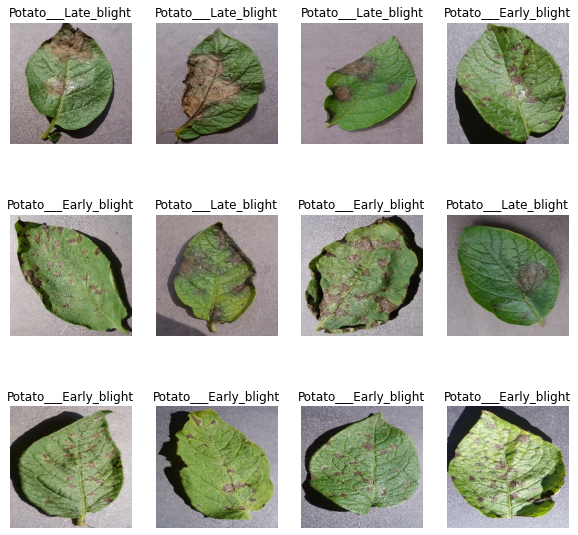

In [5]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):      # first 12 plots of first batch
    #print(image_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch.numpy()[i].astype('uint8'))
        plt.title(dataset.class_names[label_batch[i]])
        plt.axis('off')

In [18]:
def get_data_partition(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    """splitting dataset for our model"""
    
    data_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(data_size*train_split)
    val_size=int(data_size*val_split)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds
    

In [20]:
train_ds,val_ds,test_ds=get_data_partition(dataset)

In [24]:
print(len(train_ds))  # training size 
print(len(val_ds))  # validation size
print(len(test_ds))    # testing size

54
6
8


In [25]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)  # memoisation for train,validation and test data set
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
resize_and_rescale=tf.keras.Sequential([
        layers.experimental.preprocessing.Resizing(image_size,image_size), # making size of all image same 
        layers.experimental.preprocessing.Rescaling(1.0/255)   #  uniform rescaling
    ])


In [32]:
data_augmentation=tf.keras.Sequential([
    
    preprocessing.RandomFlip('horizontal_and_vertical'), # flip left-to-right
    preprocessing.RandomContrast(0.5),  # creating contrast
    preprocessing.RandomRotation(0.2),    # rotaing image
    ])

In [36]:
input_shape=(batch_size,image_size,image_size,channel)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),  # input 32 filter having kernel size of 3 by 3
    layers.MaxPool2D((2,2)),
    layers.Conv2D(16,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(16,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(3, activation='softmax'),   # output layer
])
model.build(input_shape=input_shape)

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (32, 125, 125, 16)        4624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (32, 62, 62, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (32, 60, 60, 16)         

In [38]:
model.compile(
    optimizer='nadam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [39]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    epochs=30,
    verbose=0,
)

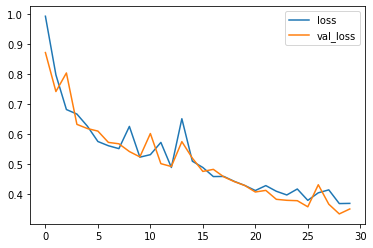

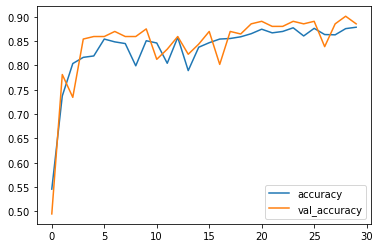

In [43]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

As shown in the above figure,both training loss and validation loss are decreasing as epochs increases.I have
done only 30 epochs becuase of my low computing power in my computer which took nearly 2.45 hrs to train.

In [90]:
predict=model.predict(image_batch)    # confidence for predicting
round(np.max(predict[0])*100,2)

74.08

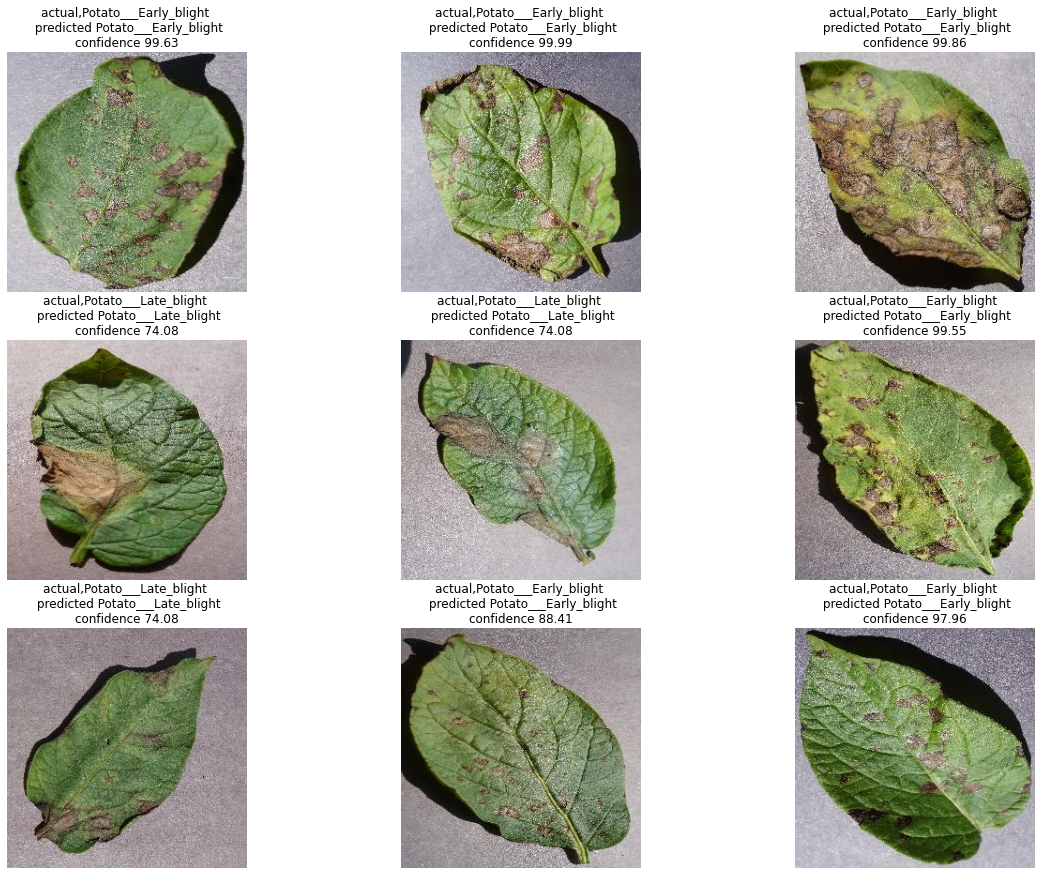

In [96]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
    plt.figure(figsize=(20,15))
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        
        predict=model.predict(image_batch)
        
        plt.title(f'actual,{dataset.class_names[label_batch[i].numpy()]} \n predicted {dataset.class_names[np.argmax(predict[i])]}\nconfidence {round(np.max(predict[i])*100,2)}')
        plt.axis('off')